# MLP SkLearn Approach

First we do some data cleaning and data exploration with plots.
Here we will use a MLP to predict the salaries.

In [54]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

path = 'Salary_Data.csv'

df = pd.read_csv(path)
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


### Salary distribution

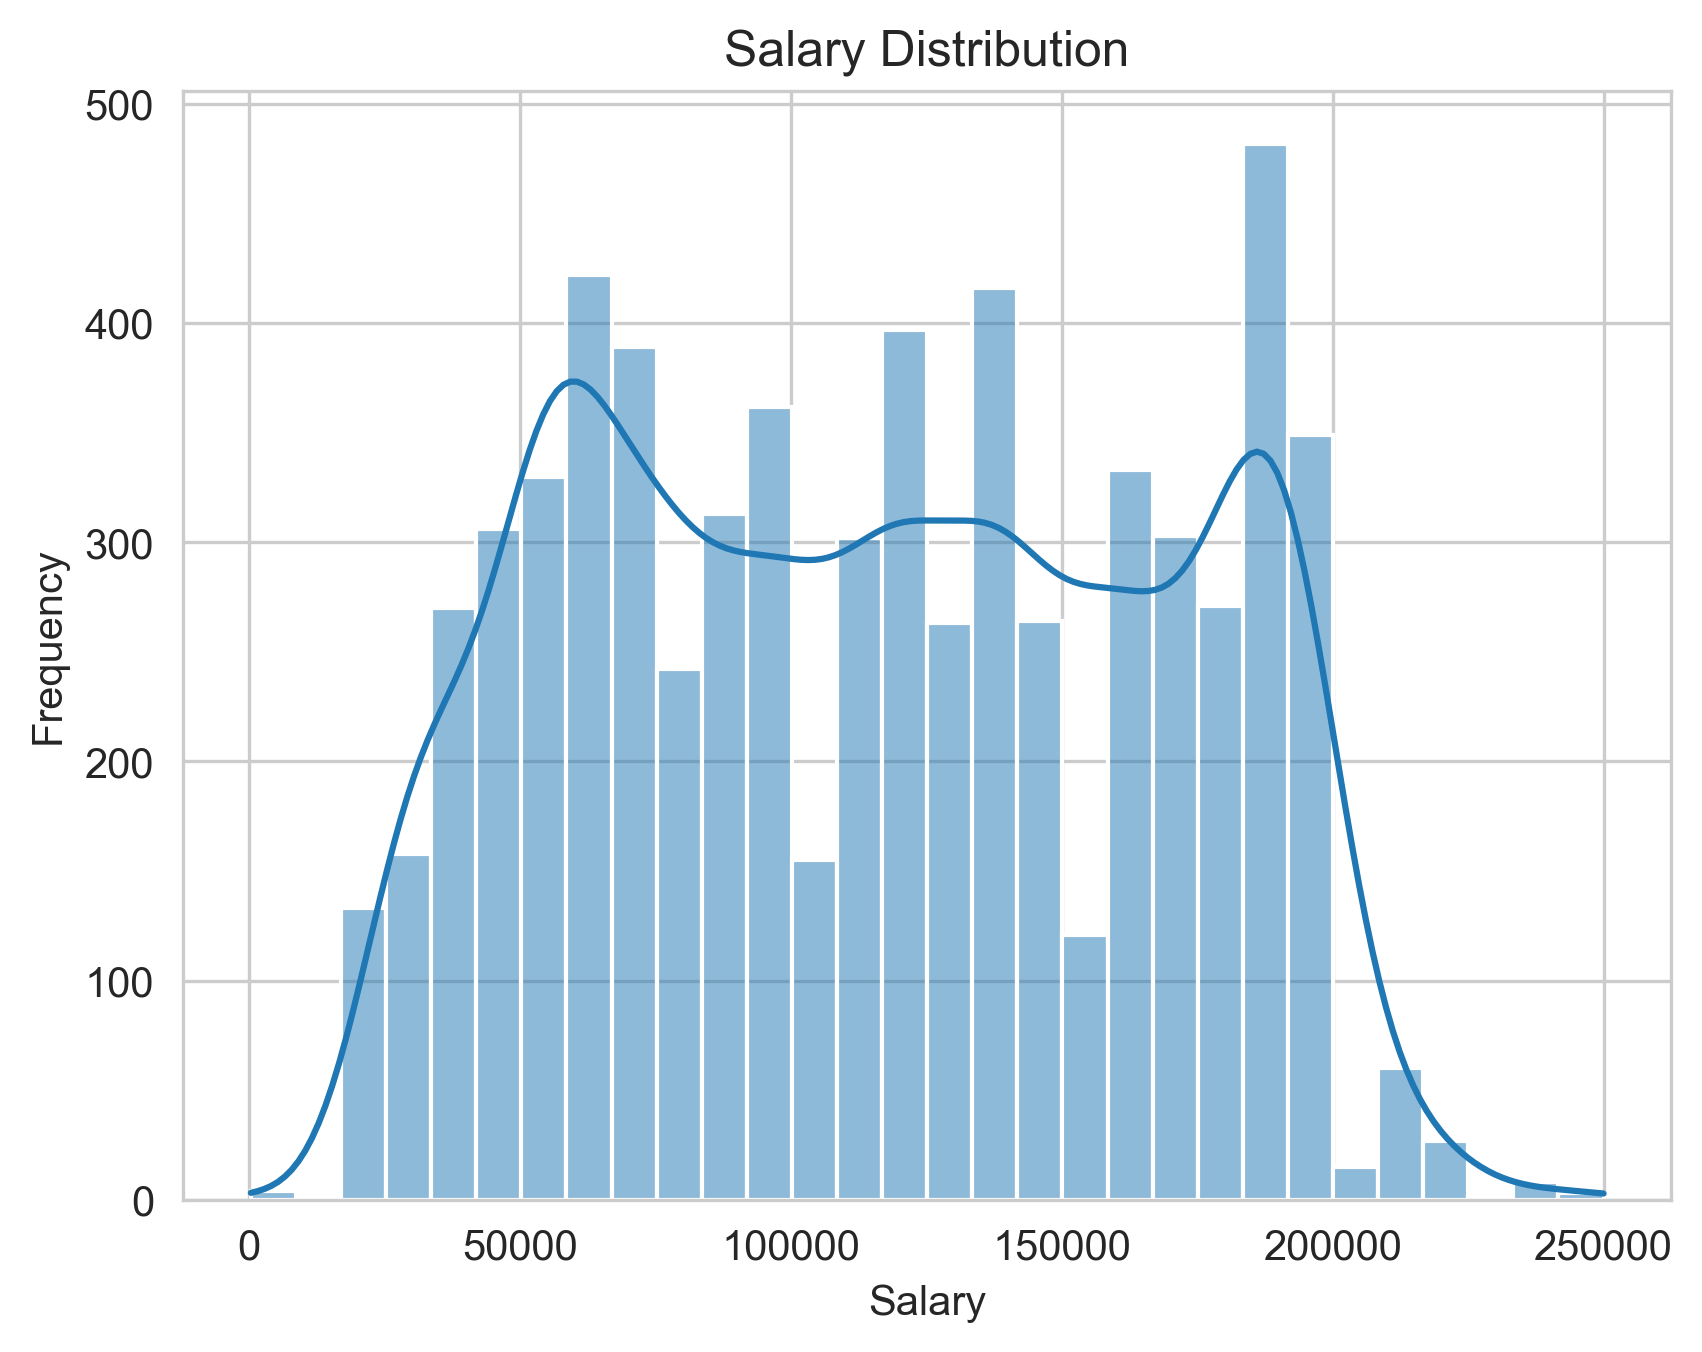

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure with high resolution
plt.figure(dpi=300)

# Bar plot the salary distribution and fit line to the bar plot
sns.histplot(df['Salary'], bins=30, kde=True)
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.title('Salary Distribution')
plt.show()

In [56]:
df.shape

(6704, 6)

# Data Cleaning

In [57]:
df['Education Level'].value_counts()

Education Level
Bachelor's Degree    2267
Master's Degree      1573
PhD                  1368
Bachelor's            756
High School           448
Master's              288
phD                     1
Name: count, dtype: int64

In [58]:
print(df.columns)
print(type(df.Salary[0]))
print(type(df['Years of Experience'][0]))

Index(['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience',
       'Salary'],
      dtype='object')
<class 'numpy.float64'>
<class 'numpy.float64'>


In [59]:
df['Education Level'] = df['Education Level'].replace("Bachelor's Degree", "Bachelor's")
df['Education Level'] = df['Education Level'].replace("phD", "PhD")
df['Education Level'] = df['Education Level'].replace("Master's Degree", "Master's")

df['Education Level'].value_counts()

Education Level
Bachelor's     3023
Master's       1861
PhD            1369
High School     448
Name: count, dtype: int64

Text(0, 0.5, 'Salary')

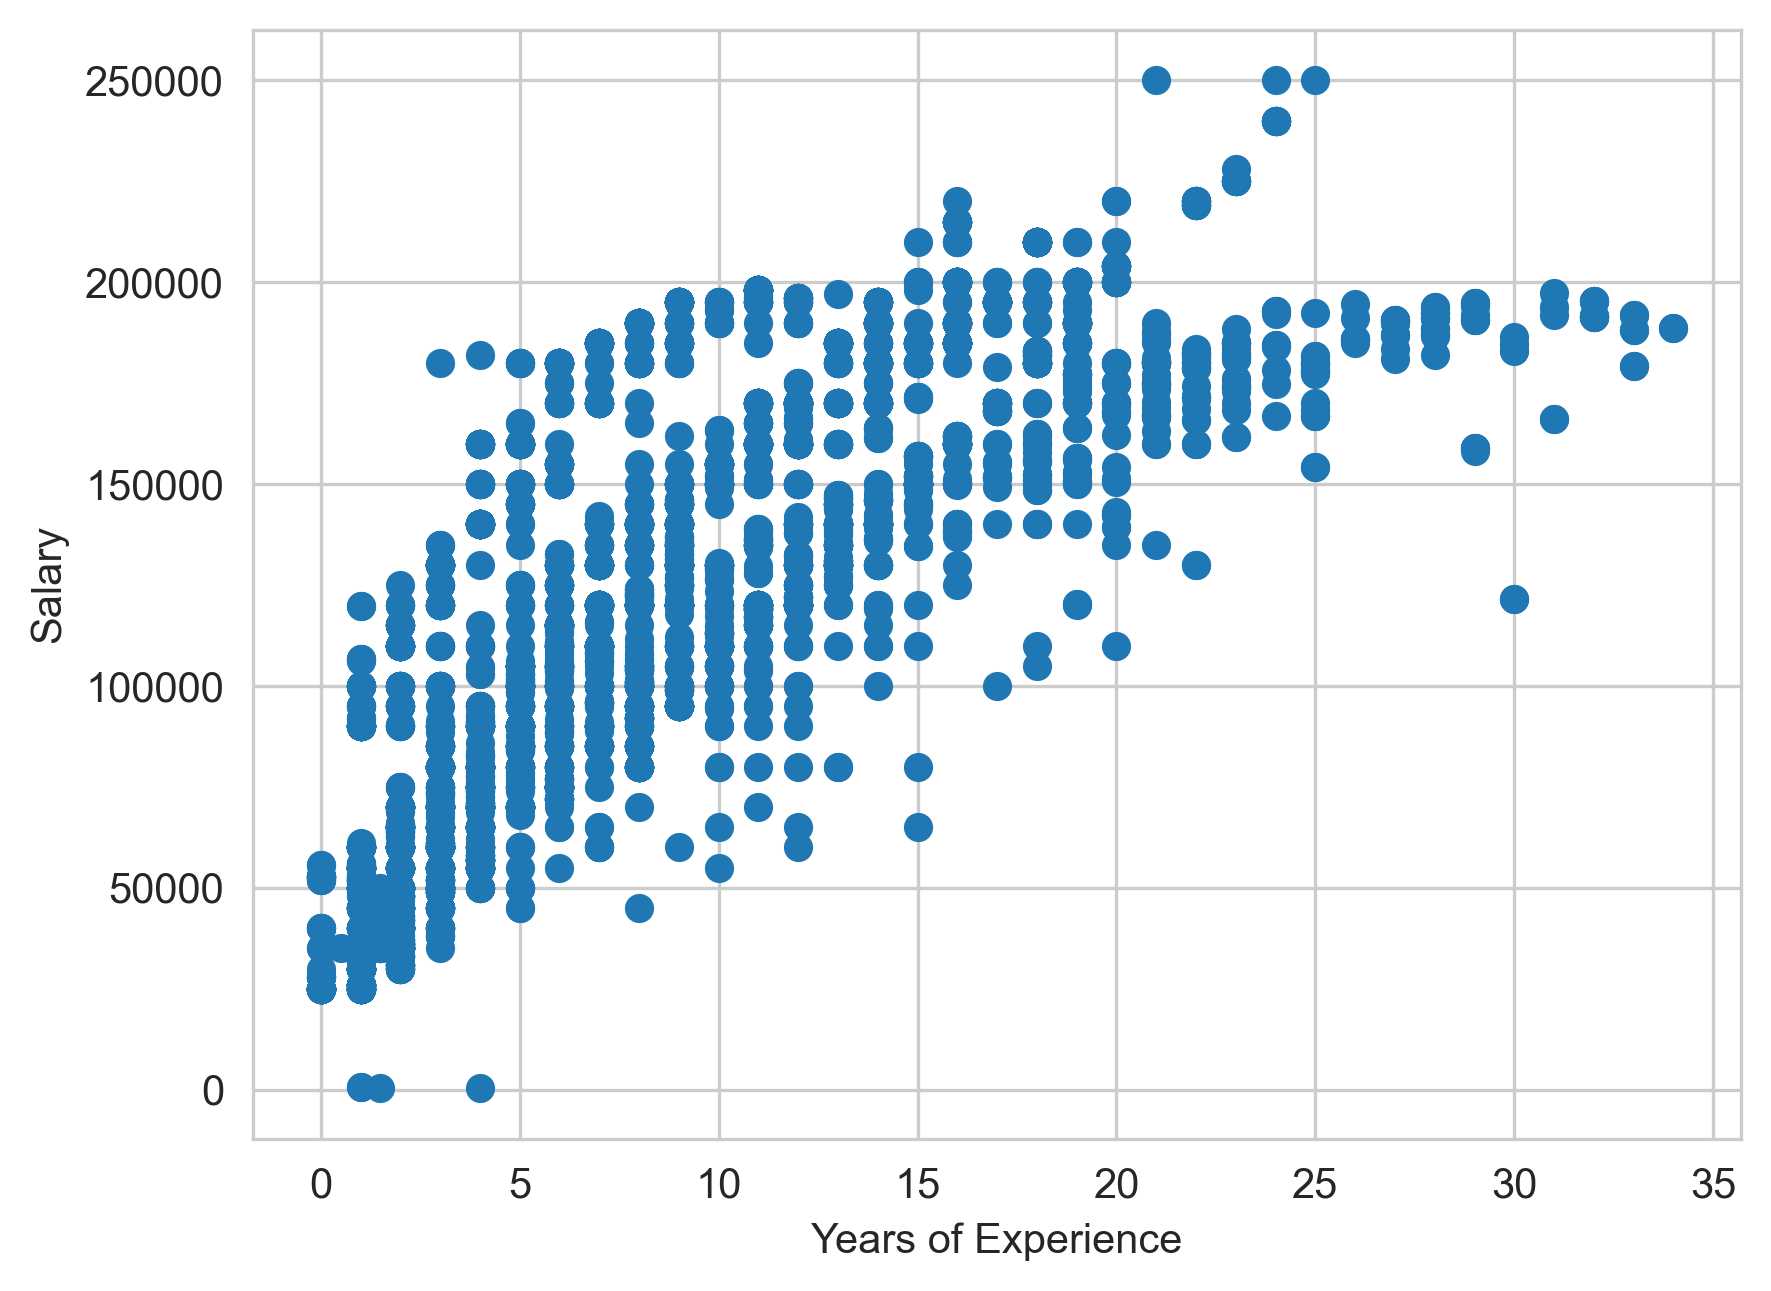

In [60]:
plt.figure(dpi=300)
plt.scatter(df['Years of Experience'], df['Salary'])
plt.xlabel('Years of Experience')
plt.ylabel('Salary')


/var/folders/v9/n514v4yd4hn8vqwrpj4cdt8c0000gn/T/ipykernel_19238/2405638058.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Education Level')['Salary'].mean().plot(kind='bar')


<Axes: xlabel='Education Level'>

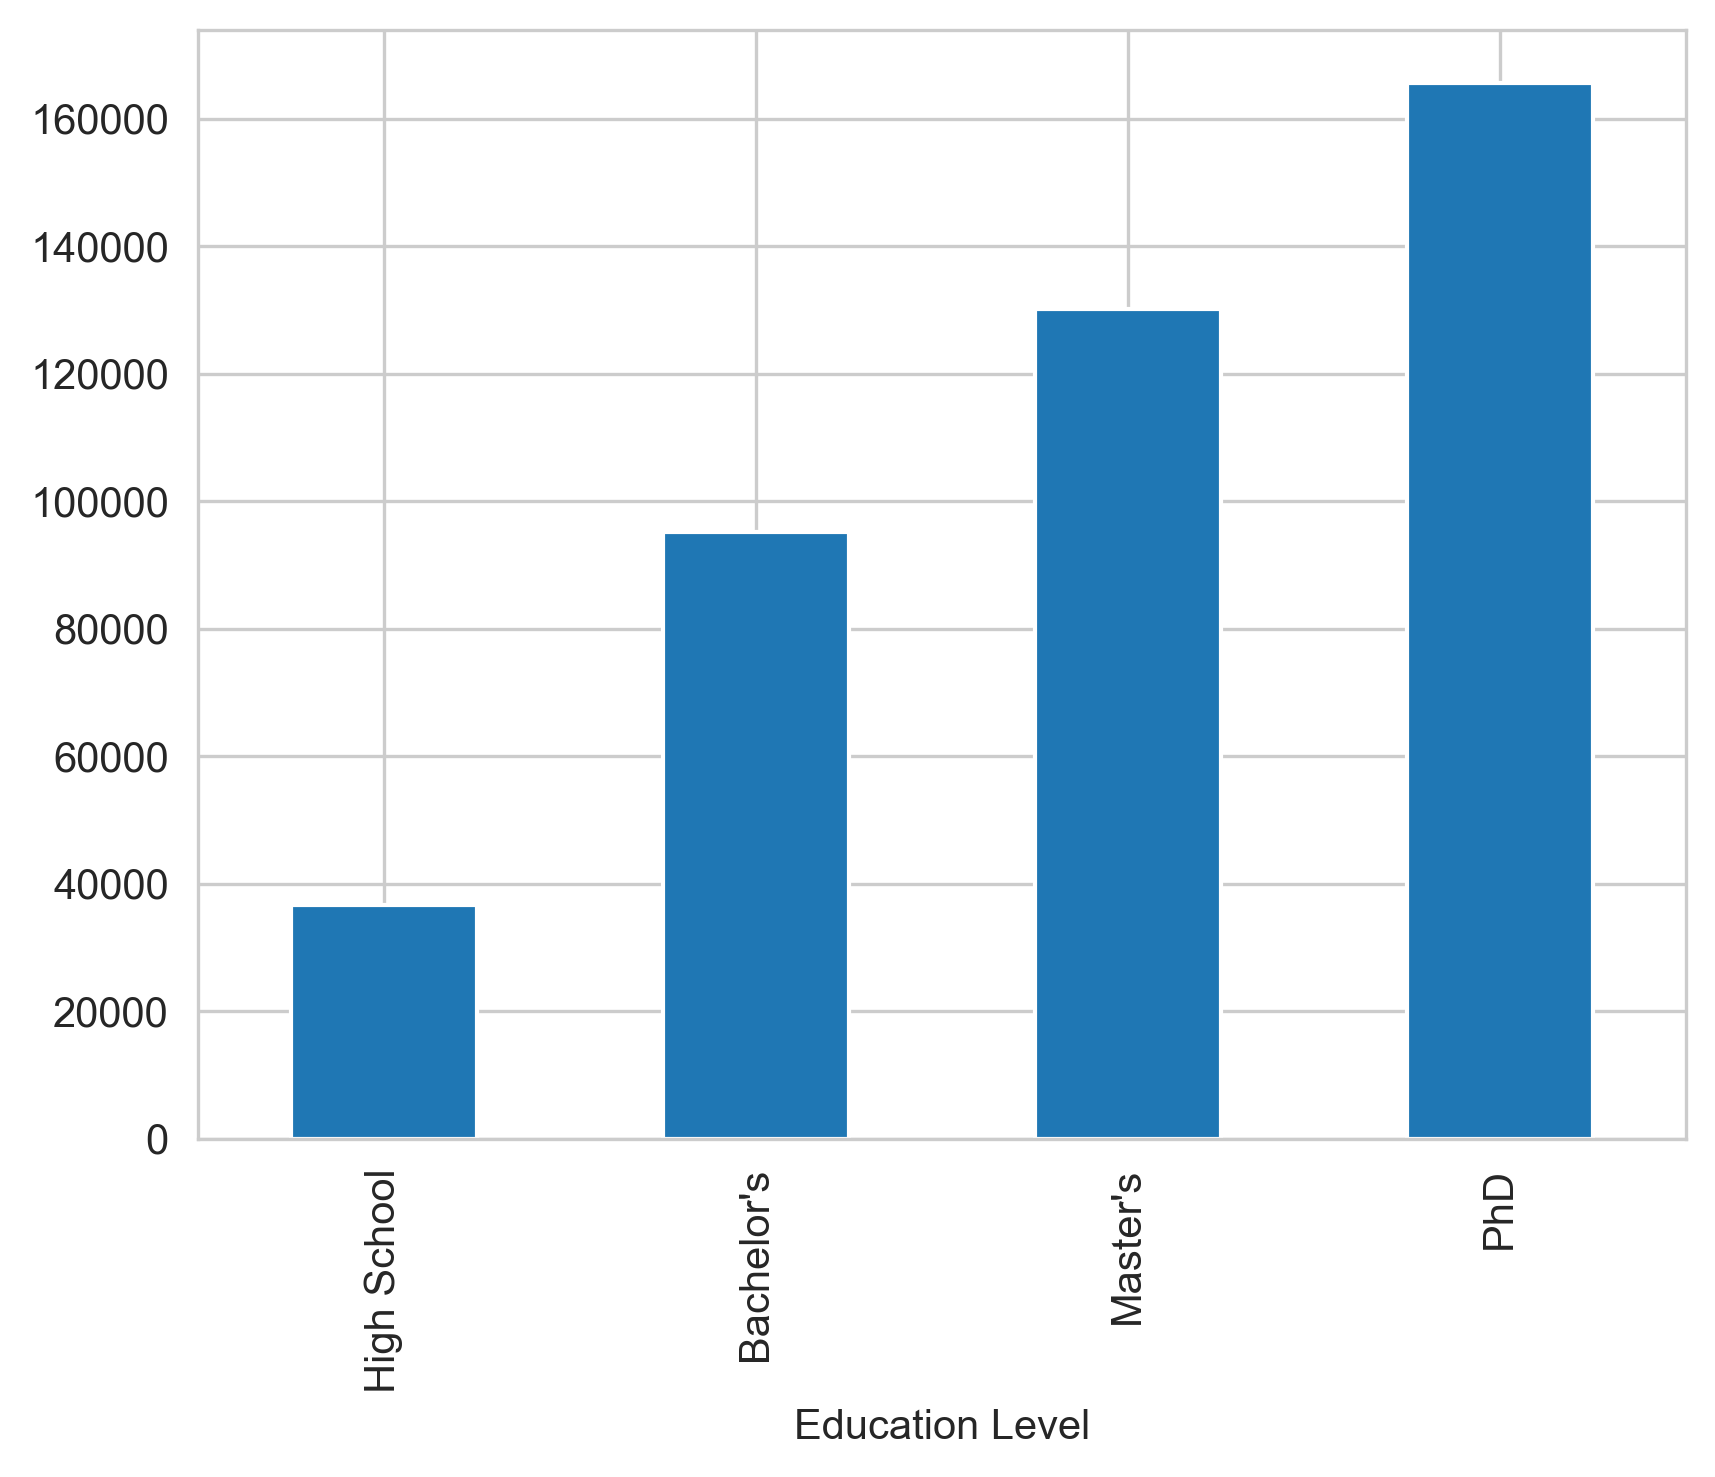

In [61]:
plt.figure(dpi=300)
df['Education Level'] = pd.Categorical(df['Education Level'], categories=['High School', 'Bachelor\'s', 'Master\'s', 'PhD'], ordered=True)

df.groupby('Education Level')['Salary'].mean().plot(kind='bar')

In [62]:
df['Job Title'].value_counts()

Job Title
Software Engineer             518
Data Scientist                453
Software Engineer Manager     376
Data Analyst                  363
Senior Project Engineer       318
                             ... 
Account Manager                 1
Help Desk Analyst               1
Senior Training Specialist      1
Junior Web Designer             1
Supply Chain Analyst            1
Name: count, Length: 193, dtype: int64

In [63]:
# Remove Jobs with less than 10 data points
df = df.groupby('Job Title').filter(lambda x: len(x) > 100)
df['Job Title'].value_counts()

Job Title
Software Engineer            518
Data Scientist               453
Software Engineer Manager    376
Data Analyst                 363
Senior Project Engineer      318
Product Manager              313
Full Stack Engineer          309
Marketing Manager            255
Senior Software Engineer     244
Back end Developer           244
Front end Developer          241
Marketing Coordinator        158
Junior Sales Associate       142
Financial Manager            134
Marketing Analyst            132
Software Developer           125
Operations Manager           114
Human Resources Manager      104
Name: count, dtype: int64

# Prepare data

In [64]:
import joblib

df = df.dropna()

education_mapping = {'High School': 0, 'Bachelor\'s': 1, 'Master\'s': 2, 'PhD': 3}
df['Education Level'] = df['Education Level'].map(lambda x: education_mapping.get(x, x)).copy()

df = df[df['Gender'] != 'Other']
gender_mapping = {'Male': 0, 'Female': 1}
df['Gender'] = df['Gender'].map(lambda x: gender_mapping.get(x, x)).copy()

train, test = train_test_split(df, test_size=0.2, random_state=42)

target_column = "Salary"
sensitive_feature = ['Age', 'Gender']
features = train.columns.difference([target_column])

scaler = StandardScaler()

train[['Years of Experience', 'Salary', 'Age']] = scaler.fit_transform(train[['Years of Experience', 'Salary', 'Age']])
test[['Years of Experience', 'Salary', 'Age']] = scaler.transform(test[['Years of Experience', 'Salary', 'Age']])

joblib.dump(scaler, "scaler_preds")

encoder = LabelEncoder()
train['Job Title'] = encoder.fit_transform(train['Job Title'])
test['Job Title'] = encoder.transform(test['Job Title'])

X_train = pd.DataFrame((train),columns = features)
y_train = pd.DataFrame((train),columns = [target_column])
X_test = pd.DataFrame((test),columns = features)
y_test = pd.DataFrame((test),columns = [target_column])

In [24]:
X_train

,Age,Education Level,Gender,Job Title,Years of Experience
1302,-0.498831,2,1,0,-0.394105
6161,-0.626409,1,0,8,-0.719872
604,-1.009142,1,0,1,-0.882756
5787,-0.498831,1,1,9,-0.556988
3927,1.032101,3,0,2,0.908967
...,...,...,...,...,...
6242,0.776946,1,1,3,1.234735
819,-0.371254,1,0,1,0.094547
3860,-0.498831,1,0,11,-0.556988
5008,-0.498831,2,0,3,-0.231221


# Training For All Jobs

In [15]:
selected_features = ['Years of Experience', 'Education Level','Age', 'Gender', 'Job Title']
model_all = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=42,alpha=0.001)
model_all.fit(X_train[selected_features], y_train)

y_pred = model_all.predict(X_test[selected_features])
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Inverse transform to original salary
y_test_pred_unscaled = scaler.inverse_transform(
    np.concatenate((X_test[['Years of Experience']].values, y_pred.reshape(-1, 1), X_test[['Age']].values), axis=1))[:, 1]

sum_error_all = 0

for i, pred in enumerate(y_test_pred_unscaled):
    actual_salary = scaler.inverse_transform(test[['Years of Experience', 'Salary', 'Age']].values)[i][1]
    sum_error_all += abs(pred - actual_salary)/ len(y_test_pred_unscaled)
    
print(f"Average Error: {sum_error_all}")

/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 0.12582112480807192
Average Error: 12167.732045874141


## Define Feature importance ALL JOBS

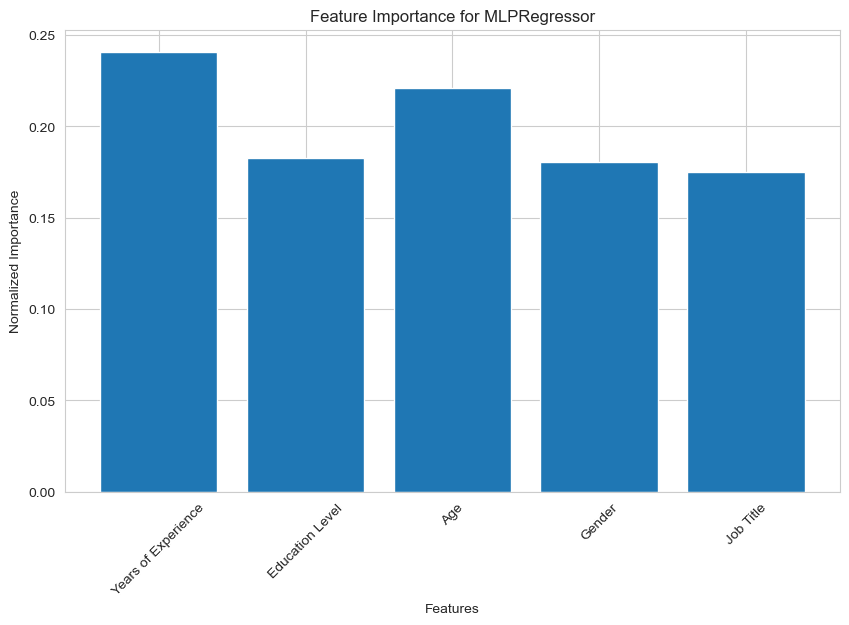

In [16]:
import matplotlib.pyplot as plt
import numpy as np

input_to_hidden_weights = model_all.coefs_[0]
feature_importances = np.sum(np.abs(input_to_hidden_weights), axis=1)

feature_importances_normalized = feature_importances / np.sum(feature_importances)

if len(feature_importances_normalized) != len(selected_features):
    print("Warning: Mismatch between features and importances. Adjusting...")
    min_length = min(len(feature_importances_normalized), len(selected_features))
    feature_importances_normalized = feature_importances_normalized[:min_length]
    selected_features = selected_features[:min_length]

plt.figure(figsize=(10, 6))
plt.bar(selected_features, feature_importances_normalized)
plt.xlabel('Features')
plt.ylabel('Normalized Importance')
plt.title('Feature Importance for MLPRegressor')
plt.xticks(rotation=45)
plt.show()

# Training For Data Scientist

In [17]:
data_scientist_train = train[train['Job Title'] == encoder.transform(['Data Scientist'])[0]]
data_scientist_test = test[test['Job Title'] == encoder.transform(['Data Scientist'])[0]]

X_train_ds = pd.DataFrame(data_scientist_train, columns=features)
y_train_ds = pd.DataFrame(data_scientist_train, columns=[target_column])
X_test_ds = pd.DataFrame(data_scientist_test, columns=features)
y_test_ds = pd.DataFrame(data_scientist_test, columns=[target_column])

selected_features = ['Years of Experience', 'Education Level', 'Age', 'Gender']
model_ds = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=42, alpha=0.001)
model_ds.fit(X_train_ds[selected_features], y_train_ds)

y_pred_ds = model_ds.predict(X_test_ds[selected_features])
mse_ds = mean_squared_error(y_test_ds, y_pred_ds)
print(f'Mean Squared Error for Data Scientist: {mse_ds}')

y_test_pred_unscaled_ds = scaler.inverse_transform(
    np.concatenate((X_test_ds[['Years of Experience']].values, y_pred_ds.reshape(-1, 1), X_test_ds[['Age']].values), axis=1)
)[:, 1]

sum_error_ds = 0

for i, pred in enumerate(y_test_pred_unscaled_ds):
    actual_salary = scaler.inverse_transform(
        data_scientist_test[['Years of Experience', 'Salary', 'Age']].values
    )[i][1]
    sum_error_ds += abs(pred - actual_salary) / len(y_test_pred_unscaled_ds)
    
print(f"Average Error for Data Scientist: {sum_error_ds}")

/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error for Data Scientist: 0.05602793273580458
Average Error for Data Scientist: 6826.505157874737


### Training for Software Engineer

In [18]:
SE_train = train[train['Job Title'] == encoder.transform(['Software Engineer'])[0]]
SE_test = test[test['Job Title'] == encoder.transform(['Software Engineer'])[0]]

X_train_se = pd.DataFrame(SE_train, columns=features)
y_train_se = pd.DataFrame(SE_train, columns=[target_column])
X_test_se = pd.DataFrame(SE_test, columns=features)
y_test_se = pd.DataFrame(SE_test, columns=[target_column])

selected_features = ['Years of Experience', 'Education Level', 'Age', 'Gender']
model_se = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=42,alpha=0.001)
model_se.fit(X_train_se[selected_features], y_train_se)

y_pred_se = model_se.predict(X_test_se[selected_features])
mse_se = mean_squared_error(y_test_se, y_pred_se)
print(f'Mean Squared Error for Data Scientist: {mse_se}')

y_test_pred_unscaled_se = scaler.inverse_transform(
    np.concatenate((X_test_se[['Years of Experience']].values, y_pred_se.reshape(-1, 1), X_test_se[['Age']].values), axis=1)
)[:, 1]

sum_error_se = 0

for i, pred in enumerate(y_test_pred_unscaled_se):
    actual_salary = scaler.inverse_transform(
        SE_test[['Years of Experience', 'Salary', 'Age']].values
    )[i][1]
    sum_error_se += abs(pred - actual_salary) / len(y_test_pred_unscaled_se)
    
print(f"Average Error for Data Scientist: {sum_error_se}")

/Users/bastienjossen/anaconda3/envs/pytorch_mps/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error for Data Scientist: 0.138398513242238
Average Error for Data Scientist: 11764.016675354815
